In [43]:
# we can experiment with the following

# change block size (4 characters are taken as context)
# change embedding size (numbers used to represent a word)
# change number of neurons in hidden layer
# change batch size (higher batch size leads to more accurate gradient changes)
# change number of iterations
# change learning rate decay

In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [45]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [46]:
len(words)

32033

In [47]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [48]:
# build the dataset
# change block size (4 characters are taken as context)
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [49]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 4]), torch.Size([182625]))

In [50]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# changed embedding size
C = torch.randn((27, 100), generator=g)
# change number of neurons in hidden layer
W1 = torch.randn((400, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [51]:
sum(p.nelement() for p in parameters)

131127

In [52]:
for p in parameters:
    p.requires_grad = True

In [53]:
lossi = []
stepi = []

for i in range(20000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32 * 4,)) # changed batch size
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 400) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27])
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    if i > 10000:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

29.32134246826172
29.416839599609375
26.30748748779297
28.47408103942871
26.17997932434082
23.260231018066406
23.82777976989746
21.869853973388672
25.050975799560547
23.487218856811523
20.878646850585938
19.703386306762695
21.587631225585938
21.75389289855957
19.134897232055664
20.79646110534668
20.488000869750977
20.267742156982422
20.86891746520996
18.663204193115234
18.982118606567383
21.611797332763672
18.523311614990234
17.82275390625
16.53969955444336
16.762365341186523
19.212905883789062
17.49258041381836
15.142539978027344
16.53977394104004
16.674060821533203
16.434097290039062
19.877992630004883
16.968839645385742
18.134822845458984
16.66446876525879
15.633103370666504
14.015146255493164
18.29608726501465
16.25078582763672
17.865598678588867
18.294281005859375
15.17273998260498
14.86067008972168
14.872875213623047
14.552360534667969
15.311647415161133
16.8155460357666
15.74888801574707
14.188444137573242
13.462542533874512
11.129911422729492
13.26016902923584
16.78542518615722

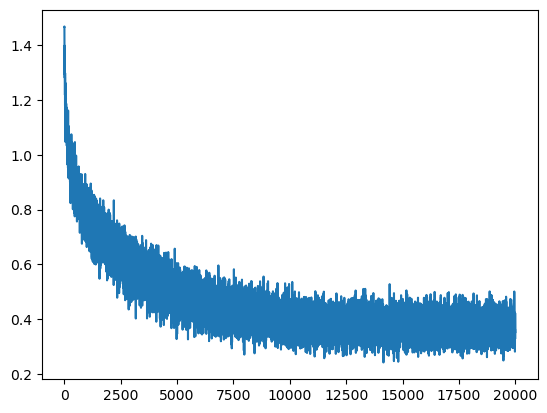

In [54]:
plt.plot(stepi, lossi)

In [55]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 400) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27])
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3496, grad_fn=<NllLossBackward0>)

In [56]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 400) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27])
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5981, grad_fn=<NllLossBackward0>)

In [57]:


# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cerillioponden.
carityn.
mellistana.
nylah.
kama.
da.
samillee.
trey.
gotti.
mozive.
kaushatte.
aren.
emma.
sade.
enia.
grrcwod.
stion.
jeray.
arlan.
kaspe.
